# **Тематическое моделирование сообщений с форума Reddit с помощью библиотеки BERTopic**

Этот проект позволяет:

1. Получить данные из Reddit
2. Очистить полученные данные
3. Провести тематическое моделирование
4. Сохранить результат в локальную базу данных SQLite 

Проект можно подстраивать под другие источники информации, что позволяет проводить разные эксперименты.

## Загрузка данных из Reddit:

### Импорт библиотек:

In [1]:
import praw
from datetime import datetime
import configparser
import time

### Инициализация Reddit API:

In [2]:
config = configparser.ConfigParser()
config.read("/home/bellap/topic_modelling_masters/config.ini")

['/home/bellap/topic_modelling_masters/config.ini']

In [3]:
reddit = praw.Reddit(
    client_id=config.get("reddit", "client_id"),
    client_secret=config.get("reddit", "client_secret"),
    user_agent=config.get("reddit", "user_agent"),
    check_for_async=False,
)

### Выбор ветки форума:

In [4]:
subreddit = reddit.subreddit("politics")

### Загрузка комментариев из самых обсуждаемых тем за день:

In [5]:
comms = []

# Получаем список самых обсуждаемых тем за день
hot_submissions = subreddit.hot(limit=None)

# Проходим по всем обсуждаемым темам
for submission in hot_submissions:
    # Проверяем, что тема была создана за последние 24 часа
    if submission.created_utc > time.time() - 24 * 60 * 60:
        submission.comments.replace_more(limit=None)
        time.sleep(0.5)  # Добавляем задержку
        for comment in submission.comments.list():
            comms.append(comment.body)

### Вывод первых результатов:

In [6]:
from pprint import pprint

In [7]:
len(comms)

10587

## Предобработка текста:

### Импорт библиотек:

In [8]:
import spacy
import re

Отключим ненужные шаги в пайплайне spaCy.

In [9]:
nlp = spacy.load(
    "en_core_web_lg",
    exclude=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"],
)

### Функция очистки текста от html элементов с помощью Regex:

In [26]:
def regex_preprocessing(text):
    text = re.sub(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
        " ",
        text,
    )
    text = re.sub(
        r"\n|\r|\<.*?\>|\{.*?\}|\[.*?\]|u/|\(.*emote.*\)|\[gif\]|_", " ", text
    )
    text = re.sub(r"[^\w0-9'’“”%!?]", " ", text)
    return text

#### Проверка Regex:

In [29]:
def test_regex_preprocessing():
    # Тесты на проверку удаления URL
    text = "Проверьте это https://example.com"
    assert regex_preprocessing(text) == "Проверьте это  "

    text = "Проверьте это http://example10.ru"
    assert regex_preprocessing(text) == "Проверьте это  "

    # Тесты на проверку удаления тегов
    text = "Счастливый <имя пользователя>"
    assert regex_preprocessing(text) == "Счастливый  "

    text = "Счастливый [слово1]"
    assert regex_preprocessing(text) == "Счастливый  "

    text = "Странная {идея*}"
    assert regex_preprocessing(text) == "Странная  "

    # Тесты на проверку удаления символов новой строки и символов профиля Reddit
    text = "\rКак дела?"
    assert regex_preprocessing(text) == " Как дела?"

    text = "\nКак дела?"
    assert regex_preprocessing(text) == " Как дела?"

    text = "Смешной u/danny!"
    assert regex_preprocessing(text) == "Смешной  danny!"

    # Тесты на проверку удаления специальных символов
    text = "Привет![gif]"
    assert regex_preprocessing(text) == "Привет! "

    text = "Привет!(emote emote-hello)"
    assert regex_preprocessing(text) == "Привет! "

    # Тест на проверку удаления лишних символов
    text = "*I don't remember summer 1992, it’s so-so far away&"
    assert (
        regex_preprocessing(text)
        == " I don't remember summer 1992  it’s so so far away "
    )


# Запуск тестов
test_regex_preprocessing()

### Функция для подготовки текста к моделированию:

BERTopic использует трансформеры. Модель лучше обучается, если получает большую информацию из текста. Поэтому, предобработка минимальная.

In [30]:
def tokenizer_preprocessing(text_list):
    texts = []
    for text in text_list:
        doc = nlp(text)
        tokens = [token.text.lower() for token in doc]
        tokens = " ".join(tokens)
        tokens = tokens.split()
        tokens = [token for token in tokens if not token.isspace()]
        tokens = [token for token in tokens if token != ""]
        tokens = " ".join(tokens)
        texts.append(tokens)
    return texts

### Удалим дубликаты и документы, в которых меньше четырех слов:

In [21]:
import pandas as pd

In [32]:
comms_data = pd.DataFrame(data=comms, columns=["comments"]).drop_duplicates(
    subset="comments", keep=False
)
comms_data = comms_data[comms_data["comments"].str.split().str.len() > 4]

In [33]:
pprint(comms_data["comments"].to_list()[:4])

['how not to treat dogs and elephants -\n'
 '\n'
 'https://scontent-atl3-2.xx.fbcdn.net/v/t39.30808-6/438253359_970464257768822_1060012302394162406_n.jpg?_nc_cat=105&ccb=1-7&_nc_sid=5f2048&_nc_ohc=4aI2yW4WQloQ7kNvgHkpHJ1&_nc_oc=Adgj0L8M715XcCwBt0UfOzUEOpvq6eSVR1VC5L9weEAIuZE0nbryXNEmnWoDNecAaKo&_nc_ht=scontent-atl3-2.xx&oh=00_AfAMIY6EBa6WDHWr_TYGO8bOBdGK6hQRpfCJjWeFLhkbdQ&oe=663C1D8B',
 '* [Doonesbury by Trudeau, April 28, '
 '2024](https://www.gocomics.com/doonesbury/2024/04/28) ...*should someone '
 "speak up about Trump's dementia?*\n"
 '\n'
 '[Pat Bagley, The Salt Lake '
 'Tribune](https://www.sltrib.com/opinion/bagley/2024/05/01/bagley-cartoon-saving-unions/)\n'
 '\n'
 '* [Saving Unions](https://i.imgur.com/zA4uCwA.png) for May Day 2024',
 'Ruben Bolling:\n'
 ' \n'
 '[The Origin of Captain '
 'Facsism](https://www.gocomics.com/tomthedancingbug/2024/05/03)',
 'Brian McFadden - [Supreme Court Fortune '
 'Telling](https://www.dailykos.com/stories/2024/5/3/2238548/-Cartoon-Supreme-Cou

### Применим функции для предобработки текста для BERTopic:

In [34]:
clean_data = comms_data["comments"].apply(regex_preprocessing).to_list()
clean_data[:4]

['how not to treat dogs and elephants     ',
 "          should someone speak up about Trump's dementia?              for May Day 2024",
 'Ruben Bolling       ',
 'Brian McFadden        Tarot for the win!']

In [35]:
clean_data = tokenizer_preprocessing(clean_data)
clean_data[:4]

['how not to treat dogs and elephants',
 "should someone speak up about trump 's dementia ? for may day 2024",
 'ruben bolling',
 'brian mcfadden tarot for the win !']

In [36]:
len(clean_data)

9799

### Повторно проверим длину строк и наличие дубликатов после очистки:

In [37]:
clean_data_df = pd.DataFrame(data=clean_data, columns=["comments"]).drop_duplicates(
    subset="comments", keep=False
)
clean_data_df = clean_data_df[clean_data_df["comments"].str.split().str.len() > 4]

In [38]:
clean_data = clean_data_df["comments"].to_list()

### Итоговый список комментариев:

In [39]:
clean_data[:4]

['how not to treat dogs and elephants',
 "should someone speak up about trump 's dementia ? for may day 2024",
 'brian mcfadden tarot for the win !',
 'ann telnaes this week ann is not fucking around with this one']

In [40]:
len(clean_data)

9567

## BERTopic:

### Импорт библиотек:

In [41]:
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance

### Настройка пайплайна BERTopic:

#### Векторное представление текстов:

Модель gte-small была выбрана с помощью бенчмарка от Hugging Face. Легкая, хорошо работает с данными из Reddit.

In [ ]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer(
    model_name_or_path="thenlper/gte-small",
    cache_folder="/home/bellap/topic_modelling_masters/transformers_cache",
)
embeddings = embedding_model.encode(clean_data, show_progress_bar=True)

#### Уменьшим размерность векторов с помощью Uniform Manifold Approximation and Projection (UMAP):

In [43]:
from umap import UMAP

#### Визуализация применения UMAP для наших данных:

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="darkgrid")

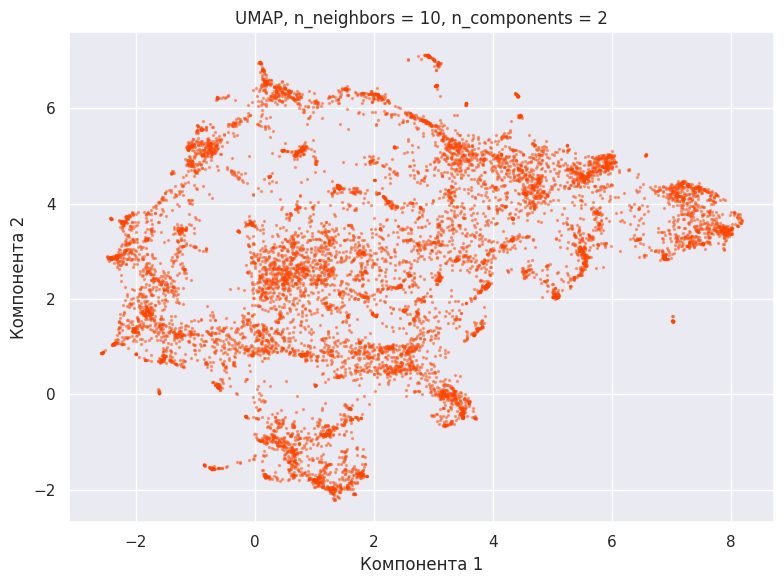

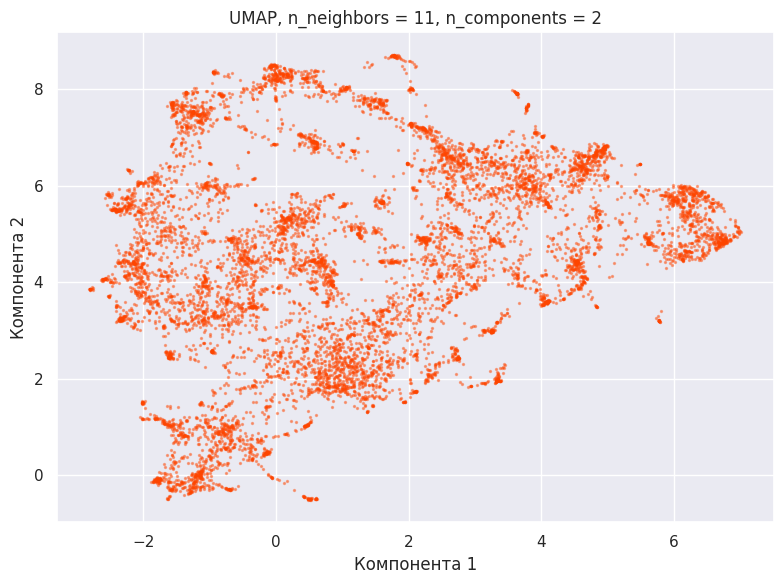

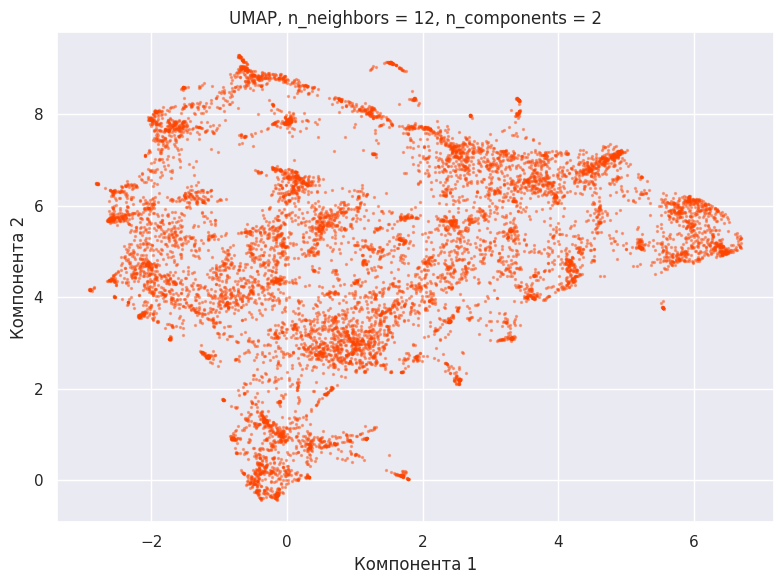

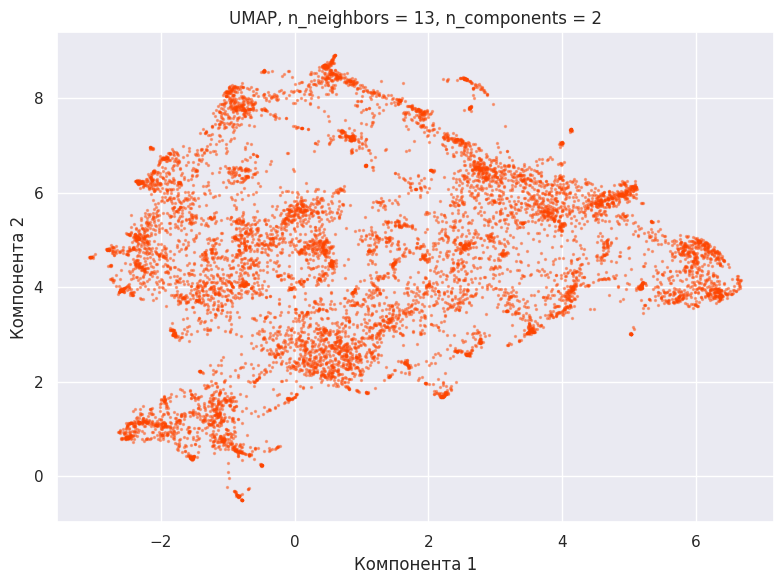

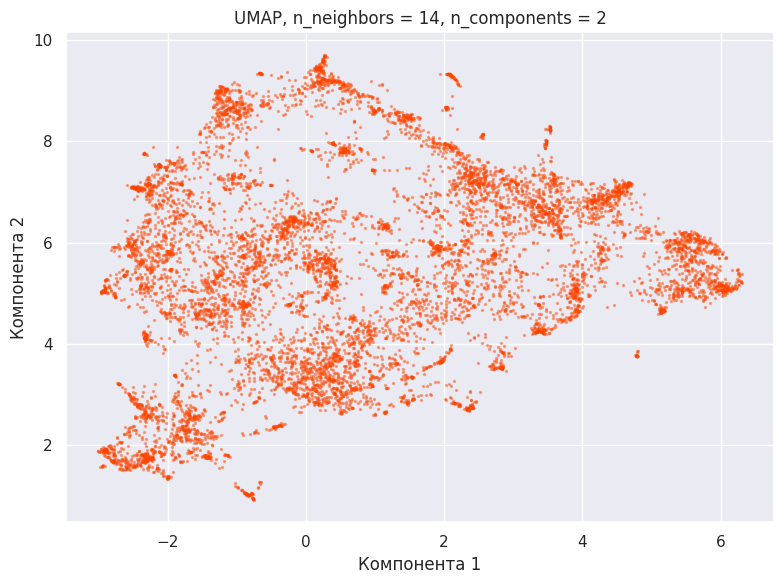

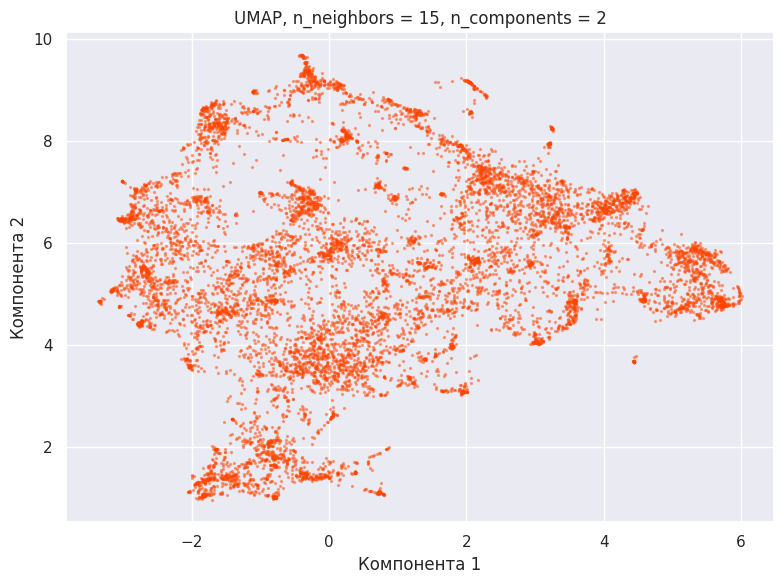

In [97]:
neighbors_list = np.arange(10, 16, 1)
for neighbors in neighbors_list:
    umap_model = UMAP(
        n_neighbors=neighbors,
        n_components=2,
        min_dist=0.0,
        low_memory=False,
        metric="cosine",
        random_state=100,
    )

    # Применяем UMAP к данным
    umap_result = umap_model.fit_transform(embeddings)

    # Визуализируем результаты
    plt.figure(figsize=(8, 6))
    plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.4, c="orangered", s=2)
    plt.title(f"UMAP, n_neighbors = {neighbors}, n_components = 2")
    plt.xlabel("Компонента 1")
    plt.ylabel("Компонента 2")
    plt.tight_layout()
    plt.show()

#### Разобьем данные на кластеры с помощью HDBSCAN:

In [46]:
from hdbscan import HDBSCAN

#### Покажем результаты кластеризации:

In [47]:
# Уменьшим размерность с помощью UMAP
umap_model = UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    low_memory=False,
    metric="cosine",
    random_state=100,
)
umap_result = umap_model.fit_transform(embeddings)

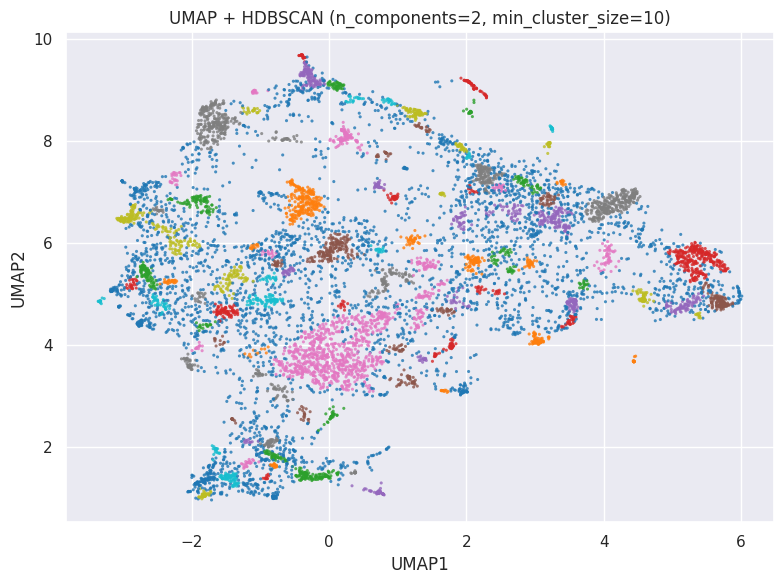

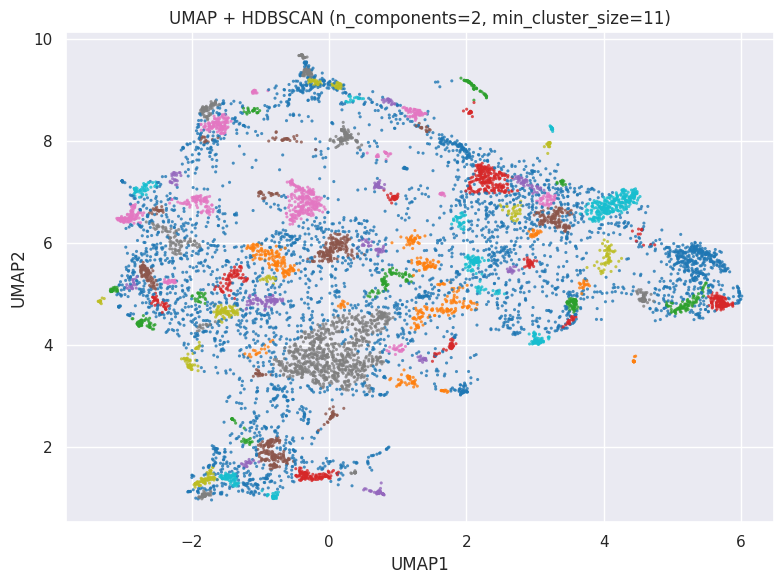

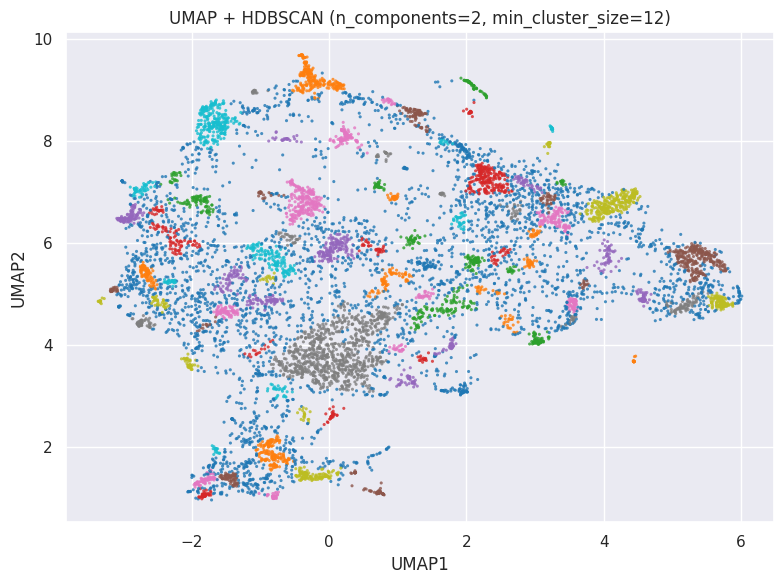

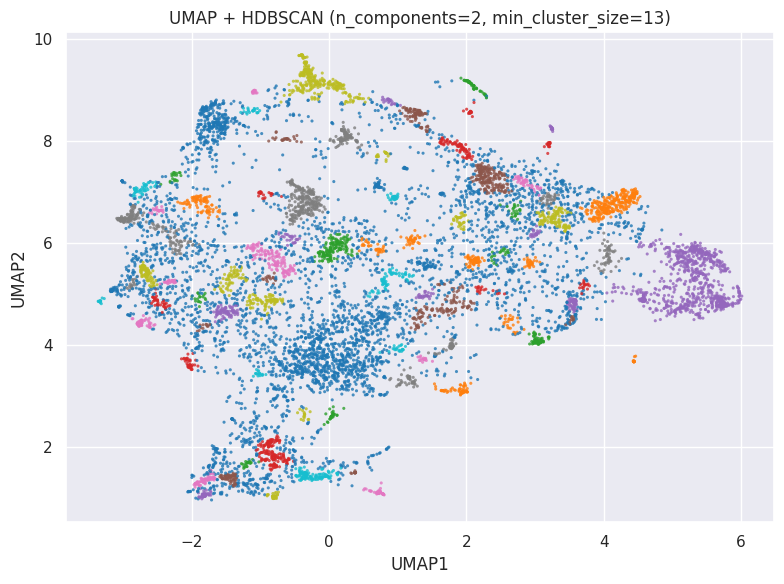

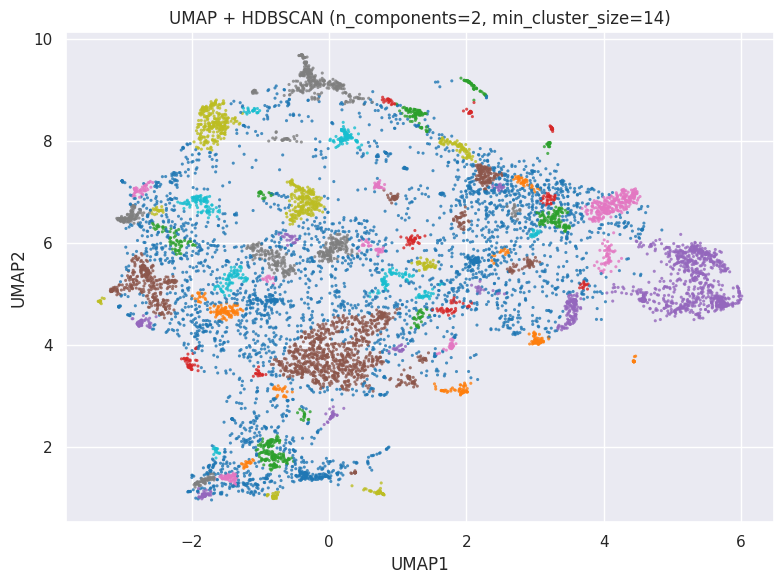

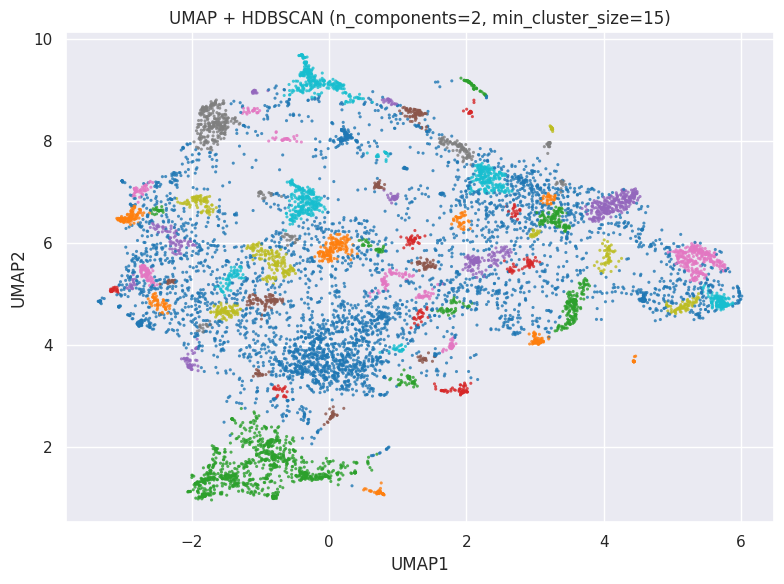

In [105]:
sizes = np.arange(10, 16, 1)
for size in sizes:
    # Кластеризуем данные с помощью HDBSCAN
    hdbscan_model = HDBSCAN(
        min_cluster_size=size, metric="euclidean", prediction_data=True
    )
    hdbscan_labels = hdbscan_model.fit_predict(umap_result)

    # Создадим DataFrame с результатами UMAP и метками HDBSCAN
    df = pd.DataFrame(umap_result, columns=[f"UMAP{i+1}" for i in range(0, 2, 1)])
    df["Cluster"] = hdbscan_labels

    # Рассеянная диаграмма для результатов UMAP
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x="UMAP1",
        alpha=0.8,
        y="UMAP2",
        hue="Cluster",
        data=df,
        palette="tab10",
        legend=None,
        linewidth=0,
        s=5,
    ).set_title(f"UMAP + HDBSCAN (n_components=2, min_cluster_size={size})")
    plt.tight_layout()
    plt.show()

#### Подставим выбранные гипермараметры для UMAP и HDBSCAN:

Гиперпараметры выбраны с учетом целей:

1. Cохранить локальную структуру данных после уменьшения размерности данных, UMAP
2. Уменьшить количество шума в кластерах, HDBSCAN
3. Создать список понятных тем на выходе

In [50]:
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    low_memory=False,
    metric="cosine",
    random_state=100,
)
hdbscan_model = HDBSCAN(min_cluster_size=15, metric="euclidean", prediction_data=True)

#### Удалим стоп-слова после распределения текстов по темам:

In [51]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(
    stop_words=list(spacy_stopwords), min_df=0.03, max_df=0.99
)

#### Запустим пайплайн и обучим модель:

Модель MaximalMarginalRelevance изменяет порядок слов в темах, чтобы убрать смысловые повторения и составить последовательность из самых значимых слов.

In [81]:
# Создаем модель BERTopic
representation_model = (
    MaximalMarginalRelevance()
)  # KeyBERTInspired() MaximalMarginalRelevance()
topic_model = BERTopic(  # Pipeline models
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    language="english",
    verbose=True,
)

# Обучаем модель
topics, probs = topic_model.fit_transform(clean_data, embeddings)

# Получаем темы
topic_representation = topic_model.get_topic_info()

2024-05-05 03:18:26,458 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-05 03:18:48,654 - BERTopic - Dimensionality - Completed ✓
2024-05-05 03:18:48,656 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-05 03:18:49,081 - BERTopic - Cluster - Completed ✓
2024-05-05 03:18:49,087 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-05 03:18:54,543 - BERTopic - Representation - Completed ✓


### Темы:

#### Выведем список тем:

In [83]:
topic_representation["Name"].to_list()

['-1_trump_vote_election_republicans',
 '0_israel_hamas_gaza_palestinians',
 '1_thank_thanks_omg_comment',
 '2_biden_vote_trump_voting',
 '3_tax_wealth_taxes_taxed',
 '4_bank_cash_billionaire_payments',
 '5_pandemic_covid_vaccine_vaccines',
 '6_protesters_protests_protest_students',
 '7_trump_president_donald_things',
 '8_woman_thought_looks_psychopath',
 '9_vp_woman_trump_melania',
 '10_states_state_federal_laws',
 '11_judges_judge_justices_federalist',
 '12_dog_puppy_killing_animal',
 '13_crime_trend_violent_cities',
 '14_kidding_attention_pressure_farted',
 '15_drugs_day_hours_uppers',
 '16_cnn_media_news_fox',
 '17_jury_juror_trial_jurors',
 '18_trans_bathroom_utah_women',
 '19_election_loses_bad_campaign',
 '20_economy_republicans_republican_democrats',
 '21_republicans_gop_republican_democrats',
 '22_asleep_sleep_sleeping_guilty',
 '23_dictator_dictatorship_americans_guns',
 '24_flu_covid_virus_spread',
 '25_dumb_idiot_stupid_narcissism',
 '26_vote_voting_candidates_candidate',
 

#### Покажем темы на графиках:

In [92]:
import plotly.io as pio

pio.renderers.default = "notebook+vscode+jupyterlab"

In [93]:
topic_model.visualize_topics(width=800, height=800)

In [94]:
topic_model.visualize_hierarchy(width=800)

#### Создадим датафрейм с данными:

In [ ]:
topics_bert = topic_representation["Name"].to_list()

# Получим текущую дату и время
now = datetime.now()
# Преобразуей их в строку в формате YYYYMMDD
date_str = now.strftime("%Y_%m_%d")

df_bert = pd.DataFrame(data=topics_bert, columns=["topics"])
df_bert["date"] = date_str
df_bert["size"] = df_bert.index
df_bert = df_bert[["date", "size", "topics"]]

In [ ]:
def clean_df_bert(df):
    df = re.sub(r"-", "", df)
    df = re.sub(r"_", " ", df)
    df = re.sub(r"\b\d+\b", "", df, count=1)
    df = re.sub("^ ", "", df)
    return df

In [ ]:
df_bert["topics"] = df_bert["topics"].apply(clean_df_bert)
print(df_bert)

           date  size                                   topics
0    2024_04_12     0             trump vote republicans biden
1    2024_04_12     1                 gun guns checks loophole
2    2024_04_12     2           rural communities areas racist
3    2024_04_12     3         traitor wishes objection treason
4    2024_04_12     4            convention dnc democrats dems
..          ...   ...                                      ...
98   2024_04_12    98             students teacher teachers mr
99   2024_04_12    99  asshole dignity hypocrisy disrespectful
100  2024_04_12   100        election november early headlines
101  2024_04_12   101          story grandma character stories
102  2024_04_12   102            newsweek headline opinion ads

[103 rows x 3 columns]


### Сохраним результат моделирования за день в формате csv:

CSV файлы используем для подстраховки, на случай неисправной работы базы данных.

In [ ]:
def save_dataframe(df):
    # Получите текущую дату и время
    now = datetime.now()

    # Преобразуйте их в строку в формате YYYYMMDD
    date_str = now.strftime("%Y_%m_%d")

    # Сохраните DataFrame в CSV-файл с текущей датой в имени файла
    df.to_csv(
        f"/home/bellap/topic_modelling/csvs/{subreddit.display_name}/{subreddit.display_name}_topics_{date_str}.csv",
        index=False,
    )

In [ ]:
save_dataframe(df_bert)

## Работа с базой данных SQLite:

Данные каждый день поступают в локальную БД. После накопления достаточного количества данных - можно приступать к новым исследованиям.

### Импорт библиотеки:

In [ ]:
import sqlite3

### Наполнение базы данных:

In [ ]:
# Создадим подключение к базе данных. Если базы данных не существует, она будет создана.
conn = sqlite3.connect("/home/bellap/topic_modelling/topics_database.db")

In [ ]:
# Создадим курсор для выполнения SQL-запросов
c = conn.cursor()

In [ ]:
# Преобразуем DataFrame в список кортежей
new_data_tuples = list(df_bert.itertuples(index=False, name=None))

In [ ]:
# Обходим новые данные
for row in new_data_tuples:
    # Используем команду INSERT OR REPLACE для обновления существующих строк или вставки новых
    c.execute(
        f"""
        INSERT OR REPLACE INTO {subreddit.display_name} (date, size, topics)
        VALUES (?, ?, ?)
    """,
        row,
    )

In [ ]:
# Выбор и вывод содержимого конкретной таблицы
c.execute(f"SELECT * FROM {subreddit.display_name}")
print(c.fetchall())

[('2024_04_05', '0', ' trump biden vote election'), ('2024_04_05', '1', 'israel aid gaza hamas'), ('2024_04_05', '2', 'judge jury trial court'), ('2024_04_05', '3', 'lol thanks comment shit'), ('2024_04_05', '4', 'polls vote polling voting'), ('2024_04_05', '5', 'economy inflation workforce taxes'), ('2024_04_05', '6', 'russian russia putin propaganda'), ('2024_04_05', '7', 'biden trump vote joe'), ('2024_04_05', '8', 'news newsweek fox article'), ('2024_04_05', '9', 'stock shares djt sell'), ('2024_04_05', '10', 'cruz texas ted texans'), ('2024_04_05', '11', 'signs flags flag sign'), ('2024_04_05', '12', 'states electoral votes district'), ('2024_04_05', '13', 'republicans republican conservative gop'), ('2024_04_05', '14', 'trump election supporters loses'), ('2024_04_05', '15', 'religion science theories religious'), ('2024_04_05', '16', 'bread grocery aldi shopping'), ('2024_04_05', '17', 'touches beard touch touched'), ('2024_04_05', '18', 'maga cult trump idiots'), ('2024_04_05',

In [ ]:
# Фиксируем изменения и закрываем соединение
conn.commit()
conn.close()